In [1]:
import splitfolders
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True' #Include this to avoid kernel from dying when using frameworks

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from collections import OrderedDict
from datetime import datetime

import copy

Image distribution (Train / Val / Test per class):
        test  train  val
Myopia     7     35    8
Normal     7     35    8


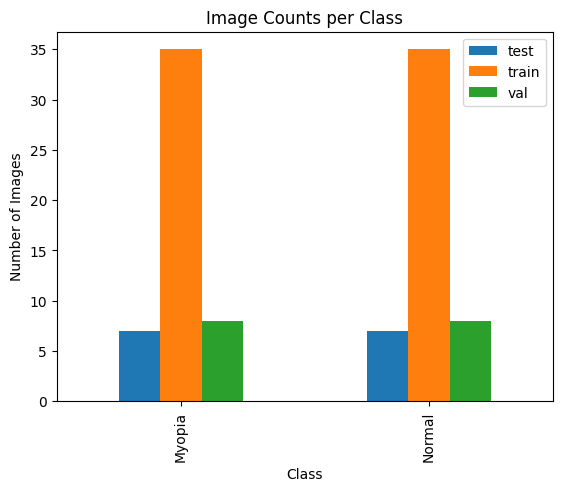


Total images per split:
test     14
train    70
val      16
dtype: int64

Total images overall: 100


In [2]:
OUTPUT_DIR = "../data/refractive error/split non-augmented dataset/"

img_data = {}

# Walk through dataset folder
for folder in os.listdir(OUTPUT_DIR):  # e.g., train / val / test
    subfolder_path = os.path.join(OUTPUT_DIR, folder)
    img_data[folder] = {}
    for subfolder in os.listdir(subfolder_path):  # e.g., each class
        img_data[folder][subfolder] = len(os.listdir(os.path.join(subfolder_path, subfolder)))

# Convert to DataFrame
df = pd.DataFrame.from_dict(img_data, orient='index').T

# Print actual numbers
print("Image distribution (Train / Val / Test per class):")
print(df)

# Plot bar chart
ax = df.plot(kind='bar')
plt.title("Image Counts per Class")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

# Totals per split
print("\nTotal images per split:")
print(df.sum(axis=0))

# Grand total
print("\nTotal images overall:", df.values.sum())


In [3]:
# Augmentation
im_size = 224
train_transform = transforms.Compose([
    transforms.Resize((im_size, im_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
val_test_transform = transforms.Compose([
    transforms.Resize((im_size, im_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

 # Load data
train_data = datasets.ImageFolder(
    OUTPUT_DIR + "train", transform=train_transform
)
val_data = datasets.ImageFolder(
    OUTPUT_DIR + "val", transform=val_test_transform
)
test_data = datasets.ImageFolder(
    OUTPUT_DIR + "test", transform=val_test_transform
)

# Creating data samplers and loaders:
BATCH_SIZE = 8

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)

val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

test_loader = DataLoader(
    test_data, batch_size=BATCH_SIZE, shuffle=False
)


# Label mapping
class_mapping = train_data.class_to_idx

In [4]:
def validation(model, criterion, val_loader, device):
    val_loss = 0.0
    accuracy = 0.0

    model.eval()
    with torch.no_grad():
        for images, labels in iter(val_loader):
            images, labels = images.to(device), labels.to(device)

            output = model(images)
            val_loss += criterion(output, labels).item()

            # Auto-detect log-probs vs logits
            if torch.allclose(torch.exp(output).sum(dim=1), torch.ones(output.size(0)).to(device), atol=1e-3):
                probabilities = torch.exp(output)  # log-probs
            else:
                probabilities = torch.softmax(output, dim=1)  # logits

            equality = labels.data == probabilities.max(dim=1)[1]
            accuracy += equality.type(torch.FloatTensor).mean().item()

    return val_loss, accuracy

In [5]:
def train_model(model, optimizer, criterion, train_loader, val_loader, epochs=100, patience=5):
    
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # History lists
    plot_training_loss = []
    plot_validation_loss = []
    plot_training_acc = []
    plot_validation_acc = []
    
    # --- Early Stopping Variables ---
    best_val_loss = float('inf')
    patience_counter = 0
    # Use copy.deepcopy to save the best model weights
    best_model_wts = copy.deepcopy(model.state_dict()) 
    
    print("---Training Started---")
    start_time = datetime.now()

    for e in range(epochs):
        # Training loop
        train_loss = 0.0
        train_acc = 0.0
        model.train()
        
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()

            # Auto-detect log-probs vs logits for training accuracy
            if torch.allclose(torch.exp(output).sum(dim=1), torch.ones(output.size(0)).to(device), atol=1e-3):
                probabilities = torch.exp(output) # log-probs
            else:
                probabilities = torch.softmax(output, dim=1) # logits

            equality = labels.data == probabilities.max(dim=1)[1]
            train_acc += equality.type(torch.FloatTensor).mean().item()
            
            # Batch log
            # if (i + 1) % 20 == 0:
            #      print(
            #         f"Epoch {e+1}/{epochs} - Batch {i+1}/{len(train_loader)} - Loss: {loss.item():.4f}"
            #     )
            print(
                f"Epoch {e+1}/{epochs} - Batch {i+1}/{len(train_loader)} "
                f"- Loss: {loss.item():.4f}",
                end="\r"
            )

        # Validation loop
        validation_loss = 0.0
        val_acc = 0.0
        model.eval()
        
        with torch.no_grad():
            for images, labels in iter(val_loader):
                images, labels = images.to(device), labels.to(device)
                
                output = model(images)
                validation_loss += criterion(output, labels).item()

                # Auto-detect log-probs vs logits
                if torch.allclose(torch.exp(output).sum(dim=1), torch.ones(output.size(0)).to(device), atol=1e-3):
                    probabilities = torch.exp(output) # log-probs
                else:
                    probabilities = torch.softmax(output, dim=1) # logits

                equality = labels.data == probabilities.max(dim=1)[1]
                val_acc += equality.type(torch.FloatTensor).mean().item()
        
        # Calculate average losses and accuracy
        train_loss = train_loss / len(train_loader)
        train_acc = train_acc / len(train_loader)
        val_loss = validation_loss / len(val_loader)
        val_acc = val_acc / len(val_loader)

        # End-of-epoch log
        print(
            f"\nEpoch: {e+1}/{epochs} | "
            f"Training Loss: {train_loss:.3f} | "
            f"Validation Loss: {val_loss:.3f} | "
            f"Training Accuracy: {train_acc:.3f} | "
            f"Validation Accuracy: {val_acc:.3f}"
        )

        # --- EARLY STOPPING LOGIC ---
        if val_loss < best_val_loss:
            print(f"Validation loss decreased ({best_val_loss:.3f} --> {val_loss:.3f}). Saving model...")
            best_val_loss = val_loss
            patience_counter = 0
            best_model_wts = copy.deepcopy(model.state_dict())
        else:
            patience_counter += 1
            print(f"Validation loss did not improve. Patience: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print(f"Early stopping triggered after {patience} epochs without improvement.")
            break # Exit the training loop
        # --- END EARLY STOPPING LOGIC ---

        # Save history
        plot_training_loss.append(train_loss)
        plot_validation_loss.append(val_loss)
        plot_training_acc.append(train_acc)
        plot_validation_acc.append(val_acc)
    
    # After loop
    print("---Training Finished---")
    end_time = datetime.now()
    print('Duration: {}'.format(end_time - start_time))
    
    # Load best model weights
    print(f"Loading best model weights with validation loss: {best_val_loss:.3f}")
    model.load_state_dict(best_model_wts)
    
    # Plot results
    plt.figure(figsize=(12, 5))

    # Loss curve
    plt.subplot(1, 2, 1)
    plt.plot(plot_training_loss, label='Training Loss')
    plt.plot(plot_validation_loss, label='Validation Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss over Epochs")

    # Accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(plot_training_acc, label='Training Accuracy')
    plt.plot(plot_validation_acc, label='Validation Accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy over Epochs")

    plt.show()

    return model

In [6]:
def save_checkpoint(model, class_mapping, arch):
    """
    Save trained model weights.

    Input:
    arch(str): Model architecture
    """

    checkpoint = {
        "arch": arch,
        "class_to_idx": class_mapping,
        "model_state_dict": model.state_dict(),
    }

    timestamp = datetime.now().date().strftime("%Y%m%d")
    torch.save(checkpoint, f"./checkpoint/{timestamp}_{arch}.pth")

In [7]:
# Load pretrained ResNet50
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

In [8]:
# Freeze all layers
for parameter in model.parameters():
    parameter.requires_grad = False

In [9]:
print("Original final layer")
print(model.fc)

# Build classifier
num_classes = len(class_mapping)
num_ftrs = model.fc.in_features
classifier = nn.Linear(num_ftrs, num_classes)
model.fc = classifier

print("\nModified final layer")
print(model.fc)

Original final layer
Linear(in_features=2048, out_features=1000, bias=True)

Modified final layer
Linear(in_features=2048, out_features=2, bias=True)


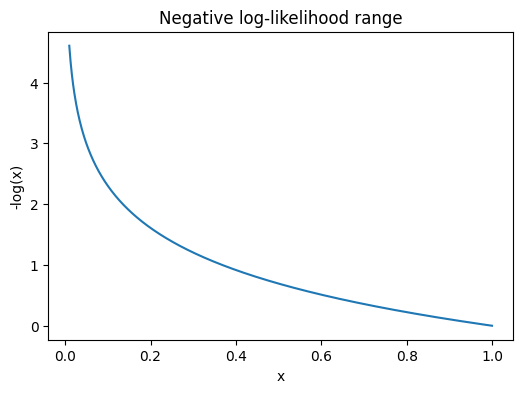

In [10]:
x = np.arange(0.01, 1.0, 0.001)
y = -np.log(x)

fig,ax = plt.subplots(figsize=(6,4))
ax.plot(x,y)
plt.ylabel('-log(x)')
plt.xlabel('x')
plt.title('Negative log-likelihood range')
plt.show()

In [11]:
# Loss function and gradient descent
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

---Training Started---


C:\Users\Nitro\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/100 - Batch 9/9 - Loss: 0.7438
Epoch: 1/100 | Training Loss: 0.685 | Validation Loss: 0.672 | Training Accuracy: 0.519 | Validation Accuracy: 0.562
Validation loss decreased (inf --> 0.672). Saving model...
Epoch 2/100 - Batch 9/9 - Loss: 0.5864
Epoch: 2/100 | Training Loss: 0.632 | Validation Loss: 0.667 | Training Accuracy: 0.704 | Validation Accuracy: 0.625
Validation loss decreased (0.672 --> 0.667). Saving model...
Epoch 3/100 - Batch 9/9 - Loss: 0.6737
Epoch: 3/100 | Training Loss: 0.616 | Validation Loss: 0.649 | Training Accuracy: 0.667 | Validation Accuracy: 0.625
Validation loss decreased (0.667 --> 0.649). Saving model...
Epoch 4/100 - Batch 9/9 - Loss: 0.4847
Epoch: 4/100 | Training Loss: 0.529 | Validation Loss: 0.622 | Training Accuracy: 0.815 | Validation Accuracy: 0.812
Validation loss decreased (0.649 --> 0.622). Saving model...
Epoch 5/100 - Batch 9/9 - Loss: 0.5609
Epoch: 5/100 | Training Loss: 0.510 | Validation Loss: 0.614 | Training Accuracy: 0.787 | Valid

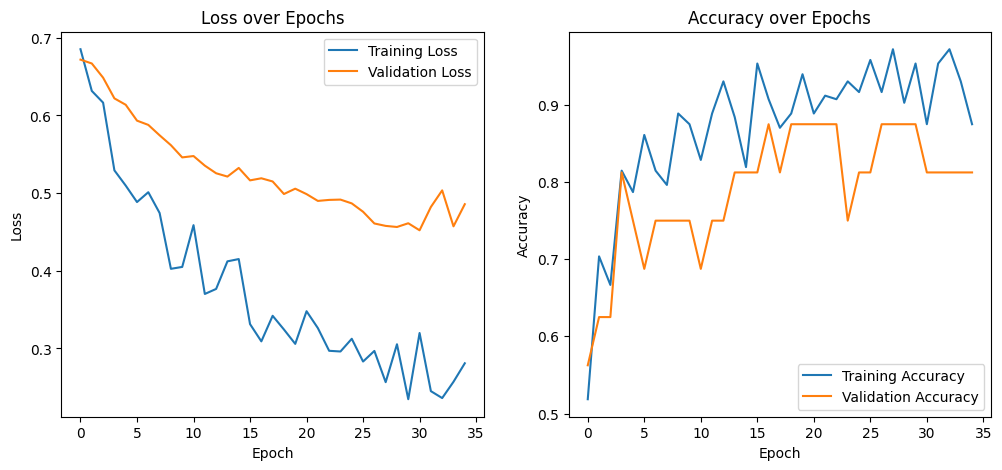

In [12]:
# Train model
resnet_model = train_model(model, optimizer, criterion, train_loader, val_loader)

In [13]:
save_checkpoint(resnet_model, class_mapping, 'resnet50')

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def test_model(model, test_loader, class_names=None, use_log_probs=True):
    device = next(model.parameters()).device  # Get model's device
    model.eval()

    predictions = []
    true_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            output = model(images)

            # If using NLLLoss (LogSoftmax), exponentiate
            if use_log_probs:
                probabilities = torch.exp(output)
            else:
                probabilities = output  # raw logits for CrossEntropyLoss

            preds = probabilities.argmax(dim=1)
            predictions.extend(preds.cpu().tolist())
            true_labels.extend(labels.cpu().tolist())

    # Determine label set
    unique_labels = sorted(set(true_labels) | set(predictions))
    if class_names is None:
        class_names = [f"Class_{i}" for i in unique_labels]
    
    # Get classification report as dict
    report_dict = classification_report(
        true_labels,
        predictions,
        target_names=class_names if class_names else None,
        output_dict=True,
        digits=4
    )

    # Extract only weighted avg + accuracy
    summary = {
        "precision": report_dict["weighted avg"]["precision"],
        "recall": report_dict["weighted avg"]["recall"],
        "f1-score": report_dict["weighted avg"]["f1-score"],
        "accuracy": report_dict["accuracy"]
    }

    print("\nSummary Metrics:")
    for k, v in summary.items():
        print(f"{k:10}: {v:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predictions, labels=unique_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


Summary Metrics:
precision : 0.8889
recall    : 0.8571
f1-score  : 0.8542
accuracy  : 0.8571


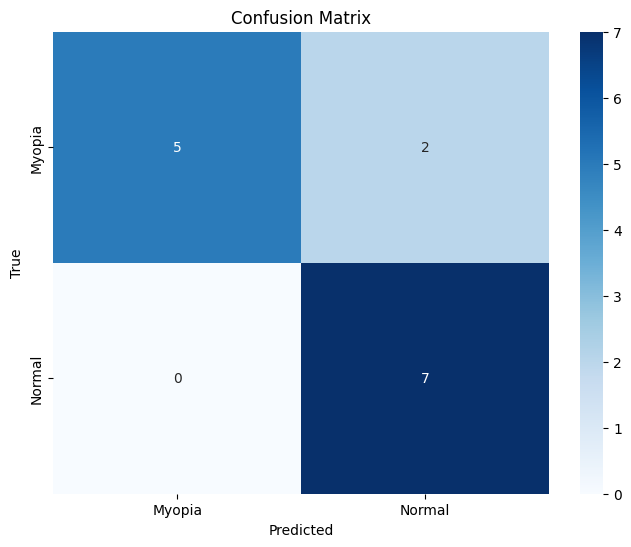

In [15]:
class_names = test_loader.dataset.classes
test_model(resnet_model, test_loader, class_names=class_names, use_log_probs=True)